# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
%config IPCompleter.greedy=True

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

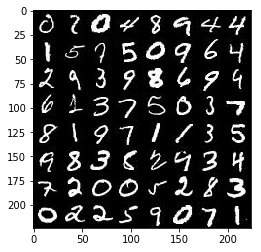

In [3]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

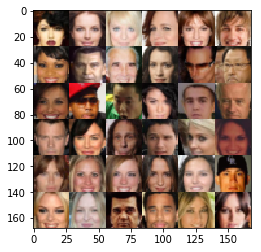

In [4]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='inputs_real')
    inputs_z=tf.placeholder(tf.float32,(None,z_dim),name='inputs_z')
    learning_rate=tf.placeholder(tf.float32,None,name='learning_rate')

    return inputs_real,inputs_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    stddev=0.02
    with tf.variable_scope('discriminator',reuse=reuse):
        x1=tf.layers.conv2d(images,32,5,strides=2,padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        relu1=tf.maximum(alpha*x1,x1)
        
        x2=tf.layers.conv2d(relu1,64,5,strides=2,padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2=tf.layers.batch_normalization(x2,training=True)
        relu2=tf.maximum(alpha*bn2,bn2)
        
        x3=tf.layers.conv2d(relu2,128,5,strides=2,padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3=tf.layers.batch_normalization(x3,training=True)
        relu3=tf.maximum(alpha*bn3,bn3)
        
        flat=tf.reshape(relu2,(-1,4*4*128))
        logits=tf.layers.dense(flat,1)
        out=tf.sigmoid(logits)

    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        alpha=0.2
        stddev=0.02
        
        x1=tf.layers.dense(z,7*7*256)
        x1=tf.reshape(x1,(-1,7,7,256))
        x1=tf.layers.batch_normalization(x1,training=is_train)
        x1=tf.maximum(alpha*x1,x1)
        
        x2=tf.layers.conv2d_transpose(x1,128,5,strides=2,padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2=tf.layers.batch_normalization(x2,training=is_train)
        x2=tf.maximum(alpha*x2,x2)
        
        x3=tf.layers.conv2d_transpose(x2,64,5,strides=2,padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3=tf.layers.batch_normalization(x3,training=is_train)
        x3=tf.maximum(alpha*x3,x3)
        
        logits=tf.layers.conv2d_transpose(x3,out_channel_dim,5,strides=1,padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        
        out=tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    g_model=generator(input_z,out_channel_dim,is_train=True)
    d_model_real,d_logits_real=discriminator(input_real,reuse=False)
    d_model_fake,d_logits_fake=discriminator(g_model,reuse=True)
    
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    d_loss_real=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    d_loss=d_loss_real+d_loss_fake
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars=tf.trainable_variables()
    d_vars=[var for var in t_vars if var.name.startswith('discriminator')]
    g_vars=[var for var in t_vars if var.name.startswith('generator')]
    
    update_ops=tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates=[opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        d_train_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt,g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    size=data_shape[1]
    dim=3 if data_image_mode=='RGB' else 1
    
    input_real,input_z,var_learning_rate=model_inputs(size,size,dim,z_dim)
    
    d_loss,g_loss=model_loss(input_real,input_z,dim)
    d_opt,g_opt=model_opt(d_loss,g_loss,var_learning_rate,beta1)
    
    samples,losses=[],[]
    steps=0
    print_every=10
    show_every=100
    
    saver=tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                images=batch_images*2
                batch_z=np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                _=sess.run(d_opt,feed_dict={
                    input_real:images,
                    input_z:batch_z,
                    var_learning_rate:learning_rate
                                           })
                
                _=sess.run(g_opt,feed_dict={
                    input_z:batch_z,
                    var_learning_rate:learning_rate
                })
                
                # At the end of each epoch,get the losses and print them out
                if steps % print_every ==0:
                    train_loss_d=d_loss.eval({input_z:batch_z,input_real:images})
                    train_loss_g=g_loss.eval({input_z:batch_z})
                    
                    print('Epoch {}/{}...'.format(epoch_i+1,epoch_count),
                         'Discriminator Loss:{:.4f}...'.format(train_loss_d),
                         'Generator Loss:{:.4f}'.format(train_loss_g))
                
                if steps % show_every ==0:
                    show_generator_output(sess,25,input_z,dim,data_image_mode)
                    
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss:1.4904... Generator Loss:0.5643
Epoch 1/2... Discriminator Loss:1.4466... Generator Loss:0.5766
Epoch 1/2... Discriminator Loss:1.3957... Generator Loss:0.6099
Epoch 1/2... Discriminator Loss:1.3976... Generator Loss:0.5996
Epoch 1/2... Discriminator Loss:1.3695... Generator Loss:0.6001
Epoch 1/2... Discriminator Loss:1.3595... Generator Loss:0.5789
Epoch 1/2... Discriminator Loss:1.3143... Generator Loss:0.6249
Epoch 1/2... Discriminator Loss:1.3062... Generator Loss:0.6971
Epoch 1/2... Discriminator Loss:1.3186... Generator Loss:0.6762
Epoch 1/2... Discriminator Loss:1.2752... Generator Loss:0.7305


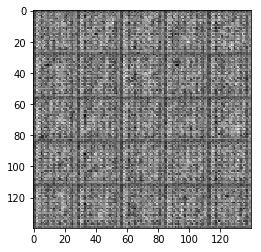

Epoch 1/2... Discriminator Loss:1.2832... Generator Loss:0.6829
Epoch 1/2... Discriminator Loss:1.3671... Generator Loss:0.6288
Epoch 1/2... Discriminator Loss:1.3581... Generator Loss:0.7222
Epoch 1/2... Discriminator Loss:1.3598... Generator Loss:0.7077
Epoch 1/2... Discriminator Loss:1.3549... Generator Loss:0.7148
Epoch 1/2... Discriminator Loss:1.3778... Generator Loss:0.7138
Epoch 1/2... Discriminator Loss:1.3471... Generator Loss:0.7626
Epoch 1/2... Discriminator Loss:1.3750... Generator Loss:0.7471
Epoch 1/2... Discriminator Loss:1.3421... Generator Loss:0.7572
Epoch 1/2... Discriminator Loss:1.3272... Generator Loss:0.7934


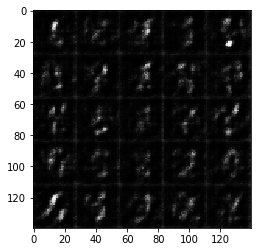

Epoch 1/2... Discriminator Loss:1.3068... Generator Loss:0.8228
Epoch 1/2... Discriminator Loss:1.3727... Generator Loss:0.7676
Epoch 1/2... Discriminator Loss:1.3627... Generator Loss:0.7794
Epoch 1/2... Discriminator Loss:1.3602... Generator Loss:0.7727
Epoch 1/2... Discriminator Loss:1.3356... Generator Loss:0.7798
Epoch 1/2... Discriminator Loss:1.3359... Generator Loss:0.7924
Epoch 1/2... Discriminator Loss:1.3631... Generator Loss:0.7751
Epoch 1/2... Discriminator Loss:1.3478... Generator Loss:0.7787
Epoch 1/2... Discriminator Loss:1.3818... Generator Loss:0.7736
Epoch 1/2... Discriminator Loss:1.3716... Generator Loss:0.7735


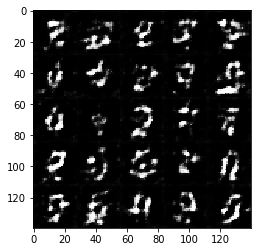

Epoch 1/2... Discriminator Loss:1.4050... Generator Loss:0.7484
Epoch 1/2... Discriminator Loss:1.3640... Generator Loss:0.7855
Epoch 1/2... Discriminator Loss:1.3851... Generator Loss:0.7862
Epoch 1/2... Discriminator Loss:1.3780... Generator Loss:0.7854
Epoch 1/2... Discriminator Loss:1.3733... Generator Loss:0.7759
Epoch 1/2... Discriminator Loss:1.3319... Generator Loss:0.7819
Epoch 1/2... Discriminator Loss:1.3512... Generator Loss:0.7756
Epoch 1/2... Discriminator Loss:1.3744... Generator Loss:0.7747
Epoch 1/2... Discriminator Loss:1.3778... Generator Loss:0.7784
Epoch 1/2... Discriminator Loss:1.3492... Generator Loss:0.7973


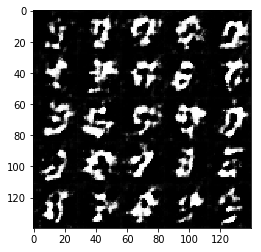

Epoch 1/2... Discriminator Loss:1.3778... Generator Loss:0.7988
Epoch 1/2... Discriminator Loss:1.3491... Generator Loss:0.7819
Epoch 1/2... Discriminator Loss:1.3770... Generator Loss:0.7710
Epoch 1/2... Discriminator Loss:1.3901... Generator Loss:0.7672
Epoch 1/2... Discriminator Loss:1.3870... Generator Loss:0.7773
Epoch 1/2... Discriminator Loss:1.3795... Generator Loss:0.7638
Epoch 1/2... Discriminator Loss:1.3582... Generator Loss:0.7947
Epoch 1/2... Discriminator Loss:1.3400... Generator Loss:0.8163
Epoch 1/2... Discriminator Loss:1.3219... Generator Loss:0.8097
Epoch 1/2... Discriminator Loss:1.3418... Generator Loss:0.8062


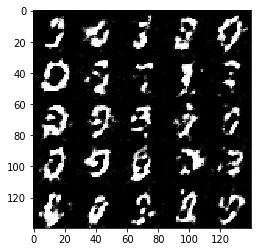

Epoch 1/2... Discriminator Loss:1.3206... Generator Loss:0.8114
Epoch 1/2... Discriminator Loss:1.3634... Generator Loss:0.7945
Epoch 1/2... Discriminator Loss:1.3351... Generator Loss:0.8080
Epoch 1/2... Discriminator Loss:1.3465... Generator Loss:0.8000
Epoch 1/2... Discriminator Loss:1.4063... Generator Loss:0.7461
Epoch 1/2... Discriminator Loss:1.3721... Generator Loss:0.7905
Epoch 1/2... Discriminator Loss:1.3481... Generator Loss:0.7988
Epoch 1/2... Discriminator Loss:1.3405... Generator Loss:0.8038
Epoch 1/2... Discriminator Loss:1.3511... Generator Loss:0.8123
Epoch 1/2... Discriminator Loss:1.3289... Generator Loss:0.8037


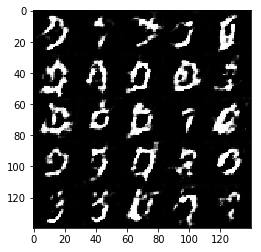

Epoch 1/2... Discriminator Loss:1.3594... Generator Loss:0.7836
Epoch 1/2... Discriminator Loss:1.3300... Generator Loss:0.7924
Epoch 1/2... Discriminator Loss:1.3376... Generator Loss:0.8049
Epoch 1/2... Discriminator Loss:1.3287... Generator Loss:0.8201
Epoch 1/2... Discriminator Loss:1.3555... Generator Loss:0.8077
Epoch 1/2... Discriminator Loss:1.3379... Generator Loss:0.8047
Epoch 1/2... Discriminator Loss:1.3383... Generator Loss:0.7984
Epoch 1/2... Discriminator Loss:1.3596... Generator Loss:0.8099
Epoch 1/2... Discriminator Loss:1.3308... Generator Loss:0.8287
Epoch 1/2... Discriminator Loss:1.3395... Generator Loss:0.8157


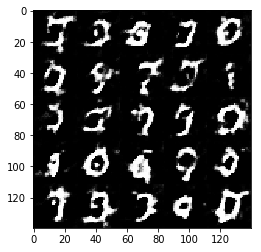

Epoch 1/2... Discriminator Loss:1.3411... Generator Loss:0.8023
Epoch 1/2... Discriminator Loss:1.3365... Generator Loss:0.8166
Epoch 1/2... Discriminator Loss:1.3325... Generator Loss:0.7961
Epoch 1/2... Discriminator Loss:1.3277... Generator Loss:0.8206
Epoch 1/2... Discriminator Loss:1.3512... Generator Loss:0.8125
Epoch 1/2... Discriminator Loss:1.3389... Generator Loss:0.8197
Epoch 1/2... Discriminator Loss:1.3457... Generator Loss:0.7973
Epoch 1/2... Discriminator Loss:1.3329... Generator Loss:0.8490
Epoch 1/2... Discriminator Loss:1.3430... Generator Loss:0.7940
Epoch 1/2... Discriminator Loss:1.3454... Generator Loss:0.7996


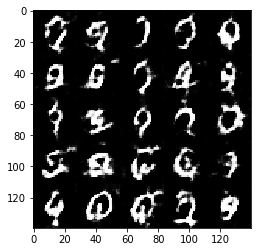

Epoch 1/2... Discriminator Loss:1.2949... Generator Loss:0.8330
Epoch 1/2... Discriminator Loss:1.3390... Generator Loss:0.8165
Epoch 1/2... Discriminator Loss:1.3196... Generator Loss:0.8097
Epoch 1/2... Discriminator Loss:1.3331... Generator Loss:0.8017
Epoch 1/2... Discriminator Loss:1.3564... Generator Loss:0.7973
Epoch 1/2... Discriminator Loss:1.3239... Generator Loss:0.8121
Epoch 1/2... Discriminator Loss:1.3227... Generator Loss:0.8251
Epoch 1/2... Discriminator Loss:1.3242... Generator Loss:0.8204
Epoch 1/2... Discriminator Loss:1.3257... Generator Loss:0.8301
Epoch 1/2... Discriminator Loss:1.3706... Generator Loss:0.7851


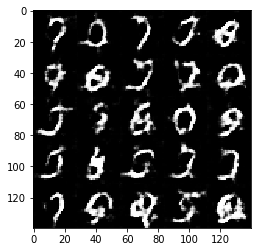

Epoch 1/2... Discriminator Loss:1.3576... Generator Loss:0.7984
Epoch 1/2... Discriminator Loss:1.3175... Generator Loss:0.8225
Epoch 1/2... Discriminator Loss:1.3218... Generator Loss:0.8228
Epoch 2/2... Discriminator Loss:1.3286... Generator Loss:0.8038
Epoch 2/2... Discriminator Loss:1.3358... Generator Loss:0.8334
Epoch 2/2... Discriminator Loss:1.3420... Generator Loss:0.7747
Epoch 2/2... Discriminator Loss:1.3405... Generator Loss:0.8074
Epoch 2/2... Discriminator Loss:1.3234... Generator Loss:0.8073
Epoch 2/2... Discriminator Loss:1.3231... Generator Loss:0.8387
Epoch 2/2... Discriminator Loss:1.2802... Generator Loss:0.8317


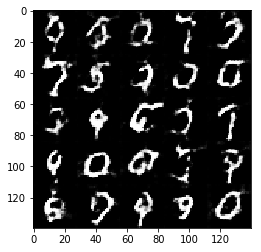

Epoch 2/2... Discriminator Loss:1.2986... Generator Loss:0.8256
Epoch 2/2... Discriminator Loss:1.3133... Generator Loss:0.8448
Epoch 2/2... Discriminator Loss:1.3232... Generator Loss:0.8528
Epoch 2/2... Discriminator Loss:1.3318... Generator Loss:0.8349
Epoch 2/2... Discriminator Loss:1.3104... Generator Loss:0.8363
Epoch 2/2... Discriminator Loss:1.3281... Generator Loss:0.8280
Epoch 2/2... Discriminator Loss:1.3249... Generator Loss:0.8202
Epoch 2/2... Discriminator Loss:1.3527... Generator Loss:0.8171
Epoch 2/2... Discriminator Loss:1.2909... Generator Loss:0.8404
Epoch 2/2... Discriminator Loss:1.3194... Generator Loss:0.8009


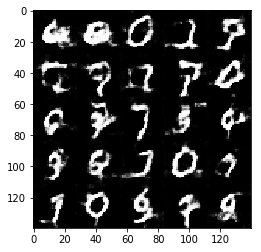

Epoch 2/2... Discriminator Loss:1.3523... Generator Loss:0.8322
Epoch 2/2... Discriminator Loss:1.3455... Generator Loss:0.8353
Epoch 2/2... Discriminator Loss:1.3334... Generator Loss:0.8122
Epoch 2/2... Discriminator Loss:1.3217... Generator Loss:0.8129
Epoch 2/2... Discriminator Loss:1.3139... Generator Loss:0.8270
Epoch 2/2... Discriminator Loss:1.3325... Generator Loss:0.8208
Epoch 2/2... Discriminator Loss:1.3218... Generator Loss:0.8257
Epoch 2/2... Discriminator Loss:1.3093... Generator Loss:0.8285
Epoch 2/2... Discriminator Loss:1.3117... Generator Loss:0.8403
Epoch 2/2... Discriminator Loss:1.3014... Generator Loss:0.8279


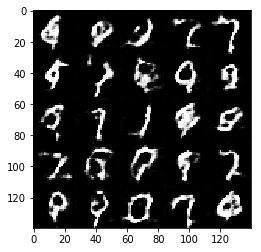

Epoch 2/2... Discriminator Loss:1.3265... Generator Loss:0.8130
Epoch 2/2... Discriminator Loss:1.3188... Generator Loss:0.8542
Epoch 2/2... Discriminator Loss:1.3195... Generator Loss:0.8186
Epoch 2/2... Discriminator Loss:1.3253... Generator Loss:0.8035
Epoch 2/2... Discriminator Loss:1.3476... Generator Loss:0.8089
Epoch 2/2... Discriminator Loss:1.3021... Generator Loss:0.8541
Epoch 2/2... Discriminator Loss:1.3447... Generator Loss:0.8305
Epoch 2/2... Discriminator Loss:1.3088... Generator Loss:0.8556
Epoch 2/2... Discriminator Loss:1.3152... Generator Loss:0.8623
Epoch 2/2... Discriminator Loss:1.2994... Generator Loss:0.8420


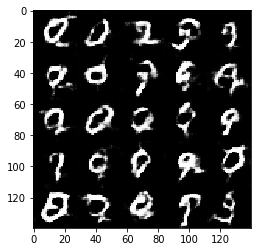

Epoch 2/2... Discriminator Loss:1.3200... Generator Loss:0.8433
Epoch 2/2... Discriminator Loss:1.3101... Generator Loss:0.8187
Epoch 2/2... Discriminator Loss:1.3290... Generator Loss:0.8214
Epoch 2/2... Discriminator Loss:1.3040... Generator Loss:0.8520
Epoch 2/2... Discriminator Loss:1.3259... Generator Loss:0.8196
Epoch 2/2... Discriminator Loss:1.2953... Generator Loss:0.8366
Epoch 2/2... Discriminator Loss:1.3498... Generator Loss:0.8245
Epoch 2/2... Discriminator Loss:1.3227... Generator Loss:0.8316
Epoch 2/2... Discriminator Loss:1.3038... Generator Loss:0.8567
Epoch 2/2... Discriminator Loss:1.2832... Generator Loss:0.8254


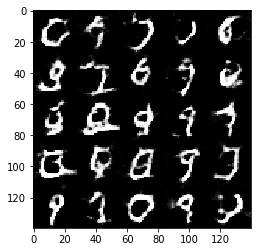

Epoch 2/2... Discriminator Loss:1.3345... Generator Loss:0.8182
Epoch 2/2... Discriminator Loss:1.3196... Generator Loss:0.8385
Epoch 2/2... Discriminator Loss:1.3121... Generator Loss:0.8304
Epoch 2/2... Discriminator Loss:1.3359... Generator Loss:0.8259
Epoch 2/2... Discriminator Loss:1.3422... Generator Loss:0.8276
Epoch 2/2... Discriminator Loss:1.3128... Generator Loss:0.8392
Epoch 2/2... Discriminator Loss:1.3119... Generator Loss:0.8545
Epoch 2/2... Discriminator Loss:1.3267... Generator Loss:0.8424
Epoch 2/2... Discriminator Loss:1.3110... Generator Loss:0.8115
Epoch 2/2... Discriminator Loss:1.3138... Generator Loss:0.8300


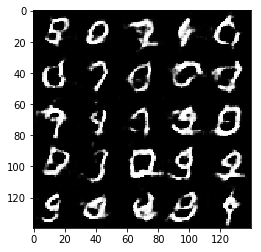

Epoch 2/2... Discriminator Loss:1.3130... Generator Loss:0.8404
Epoch 2/2... Discriminator Loss:1.3417... Generator Loss:0.8270
Epoch 2/2... Discriminator Loss:1.3333... Generator Loss:0.7862
Epoch 2/2... Discriminator Loss:1.3181... Generator Loss:0.8239
Epoch 2/2... Discriminator Loss:1.3384... Generator Loss:0.8289
Epoch 2/2... Discriminator Loss:1.3311... Generator Loss:0.8093
Epoch 2/2... Discriminator Loss:1.3053... Generator Loss:0.8171
Epoch 2/2... Discriminator Loss:1.3165... Generator Loss:0.8251
Epoch 2/2... Discriminator Loss:1.2999... Generator Loss:0.8447
Epoch 2/2... Discriminator Loss:1.3236... Generator Loss:0.8323


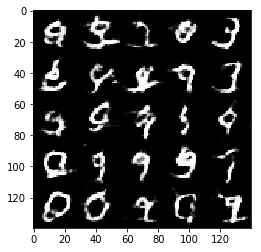

Epoch 2/2... Discriminator Loss:1.3443... Generator Loss:0.8161
Epoch 2/2... Discriminator Loss:1.3425... Generator Loss:0.8511
Epoch 2/2... Discriminator Loss:1.2949... Generator Loss:0.8291
Epoch 2/2... Discriminator Loss:1.3063... Generator Loss:0.8188
Epoch 2/2... Discriminator Loss:1.3351... Generator Loss:0.8117
Epoch 2/2... Discriminator Loss:1.3068... Generator Loss:0.8135
Epoch 2/2... Discriminator Loss:1.3151... Generator Loss:0.8263
Epoch 2/2... Discriminator Loss:1.3425... Generator Loss:0.8230
Epoch 2/2... Discriminator Loss:1.3142... Generator Loss:0.8039
Epoch 2/2... Discriminator Loss:1.3384... Generator Loss:0.8207


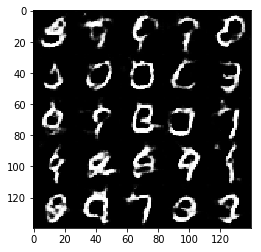

Epoch 2/2... Discriminator Loss:1.3376... Generator Loss:0.8292
Epoch 2/2... Discriminator Loss:1.3203... Generator Loss:0.8186
Epoch 2/2... Discriminator Loss:1.3216... Generator Loss:0.8153
Epoch 2/2... Discriminator Loss:1.3624... Generator Loss:0.8182
Epoch 2/2... Discriminator Loss:1.3095... Generator Loss:0.8084
Epoch 2/2... Discriminator Loss:1.3253... Generator Loss:0.8249
Epoch 2/2... Discriminator Loss:1.3114... Generator Loss:0.8243
Epoch 2/2... Discriminator Loss:1.3225... Generator Loss:0.8382
Epoch 2/2... Discriminator Loss:1.3258... Generator Loss:0.8224
Epoch 2/2... Discriminator Loss:1.3263... Generator Loss:0.8243


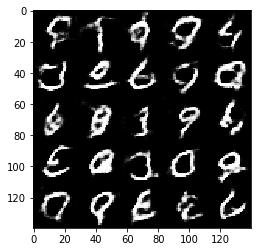

Epoch 2/2... Discriminator Loss:1.3390... Generator Loss:0.7740
Epoch 2/2... Discriminator Loss:1.3548... Generator Loss:0.7968
Epoch 2/2... Discriminator Loss:1.3247... Generator Loss:0.7941
Epoch 2/2... Discriminator Loss:1.3591... Generator Loss:0.8014
Epoch 2/2... Discriminator Loss:1.3439... Generator Loss:0.8272
Epoch 2/2... Discriminator Loss:1.3043... Generator Loss:0.8223
Epoch 2/2... Discriminator Loss:1.3284... Generator Loss:0.8604


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss:1.0280... Generator Loss:0.8784
Epoch 1/1... Discriminator Loss:0.6656... Generator Loss:1.6404
Epoch 1/1... Discriminator Loss:1.0863... Generator Loss:0.8286
Epoch 1/1... Discriminator Loss:0.8444... Generator Loss:1.7745
Epoch 1/1... Discriminator Loss:0.8546... Generator Loss:1.4981
Epoch 1/1... Discriminator Loss:1.9692... Generator Loss:4.3280
Epoch 1/1... Discriminator Loss:0.7569... Generator Loss:1.8673
Epoch 1/1... Discriminator Loss:0.9929... Generator Loss:1.6055
Epoch 1/1... Discriminator Loss:1.3350... Generator Loss:0.6394
Epoch 1/1... Discriminator Loss:1.2225... Generator Loss:0.7637


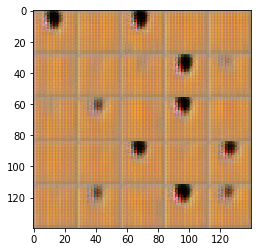

Epoch 1/1... Discriminator Loss:1.3368... Generator Loss:1.1158
Epoch 1/1... Discriminator Loss:1.4861... Generator Loss:0.6760
Epoch 1/1... Discriminator Loss:1.3671... Generator Loss:0.6029
Epoch 1/1... Discriminator Loss:1.2735... Generator Loss:0.7255
Epoch 1/1... Discriminator Loss:1.4940... Generator Loss:0.7697
Epoch 1/1... Discriminator Loss:1.3397... Generator Loss:0.7704
Epoch 1/1... Discriminator Loss:1.2809... Generator Loss:1.0526
Epoch 1/1... Discriminator Loss:1.2094... Generator Loss:0.8814
Epoch 1/1... Discriminator Loss:1.3566... Generator Loss:0.7412
Epoch 1/1... Discriminator Loss:1.3374... Generator Loss:0.7648


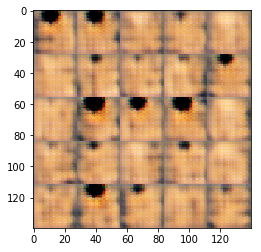

Epoch 1/1... Discriminator Loss:1.1915... Generator Loss:0.8187
Epoch 1/1... Discriminator Loss:1.4310... Generator Loss:0.6878
Epoch 1/1... Discriminator Loss:1.3019... Generator Loss:0.8708
Epoch 1/1... Discriminator Loss:1.4019... Generator Loss:0.7870
Epoch 1/1... Discriminator Loss:1.3172... Generator Loss:0.8592
Epoch 1/1... Discriminator Loss:1.4984... Generator Loss:0.8853
Epoch 1/1... Discriminator Loss:1.3459... Generator Loss:0.7333
Epoch 1/1... Discriminator Loss:1.4775... Generator Loss:0.7484
Epoch 1/1... Discriminator Loss:1.5566... Generator Loss:0.6520
Epoch 1/1... Discriminator Loss:1.3618... Generator Loss:0.7701


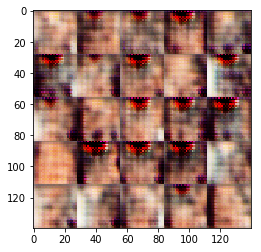

Epoch 1/1... Discriminator Loss:1.4352... Generator Loss:0.9125
Epoch 1/1... Discriminator Loss:1.4151... Generator Loss:0.8712
Epoch 1/1... Discriminator Loss:1.4207... Generator Loss:0.7476
Epoch 1/1... Discriminator Loss:1.3468... Generator Loss:0.8851
Epoch 1/1... Discriminator Loss:1.3189... Generator Loss:0.7353
Epoch 1/1... Discriminator Loss:1.4291... Generator Loss:0.7589
Epoch 1/1... Discriminator Loss:1.3505... Generator Loss:0.8422
Epoch 1/1... Discriminator Loss:1.4203... Generator Loss:0.8707
Epoch 1/1... Discriminator Loss:1.3484... Generator Loss:0.8320
Epoch 1/1... Discriminator Loss:1.3724... Generator Loss:0.8065


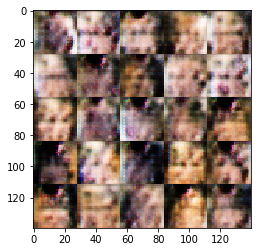

Epoch 1/1... Discriminator Loss:1.4237... Generator Loss:0.7969
Epoch 1/1... Discriminator Loss:1.2959... Generator Loss:0.8589
Epoch 1/1... Discriminator Loss:1.3616... Generator Loss:0.7285
Epoch 1/1... Discriminator Loss:1.3354... Generator Loss:0.8220
Epoch 1/1... Discriminator Loss:1.3865... Generator Loss:0.7329
Epoch 1/1... Discriminator Loss:1.3195... Generator Loss:0.8368
Epoch 1/1... Discriminator Loss:1.3396... Generator Loss:0.8167
Epoch 1/1... Discriminator Loss:1.3882... Generator Loss:0.8182
Epoch 1/1... Discriminator Loss:1.4259... Generator Loss:0.7833
Epoch 1/1... Discriminator Loss:1.4249... Generator Loss:0.7513


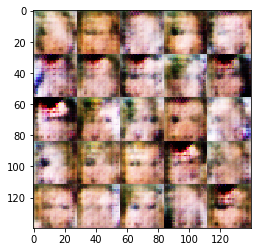

Epoch 1/1... Discriminator Loss:1.3786... Generator Loss:0.7600
Epoch 1/1... Discriminator Loss:1.3986... Generator Loss:0.7212
Epoch 1/1... Discriminator Loss:1.4937... Generator Loss:0.7718
Epoch 1/1... Discriminator Loss:1.4280... Generator Loss:0.7137
Epoch 1/1... Discriminator Loss:1.4030... Generator Loss:0.7074
Epoch 1/1... Discriminator Loss:1.4105... Generator Loss:0.7254
Epoch 1/1... Discriminator Loss:1.5417... Generator Loss:0.7137
Epoch 1/1... Discriminator Loss:1.6943... Generator Loss:0.9131
Epoch 1/1... Discriminator Loss:1.4179... Generator Loss:0.8493
Epoch 1/1... Discriminator Loss:1.3987... Generator Loss:0.7839


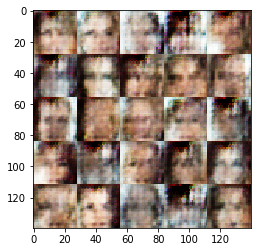

Epoch 1/1... Discriminator Loss:1.4030... Generator Loss:0.7941
Epoch 1/1... Discriminator Loss:1.4162... Generator Loss:0.7857
Epoch 1/1... Discriminator Loss:1.4282... Generator Loss:0.7536
Epoch 1/1... Discriminator Loss:1.4346... Generator Loss:0.7286
Epoch 1/1... Discriminator Loss:1.4922... Generator Loss:0.7537
Epoch 1/1... Discriminator Loss:1.3801... Generator Loss:0.8245
Epoch 1/1... Discriminator Loss:1.3863... Generator Loss:0.7622
Epoch 1/1... Discriminator Loss:1.4488... Generator Loss:0.6639
Epoch 1/1... Discriminator Loss:1.4330... Generator Loss:0.7256
Epoch 1/1... Discriminator Loss:1.3812... Generator Loss:0.7786


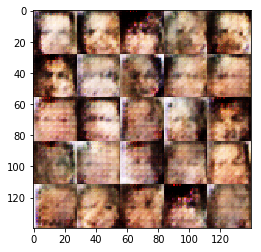

Epoch 1/1... Discriminator Loss:1.8338... Generator Loss:0.8556
Epoch 1/1... Discriminator Loss:1.3838... Generator Loss:0.7891
Epoch 1/1... Discriminator Loss:1.4418... Generator Loss:0.7345
Epoch 1/1... Discriminator Loss:1.3521... Generator Loss:0.8519
Epoch 1/1... Discriminator Loss:1.4854... Generator Loss:0.6662
Epoch 1/1... Discriminator Loss:1.4124... Generator Loss:0.8988
Epoch 1/1... Discriminator Loss:1.4111... Generator Loss:0.8070
Epoch 1/1... Discriminator Loss:1.3639... Generator Loss:0.8211
Epoch 1/1... Discriminator Loss:1.4640... Generator Loss:0.7419
Epoch 1/1... Discriminator Loss:1.4071... Generator Loss:0.8808


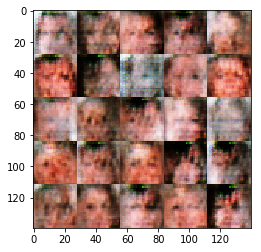

Epoch 1/1... Discriminator Loss:1.4556... Generator Loss:0.8072
Epoch 1/1... Discriminator Loss:1.3398... Generator Loss:0.8818
Epoch 1/1... Discriminator Loss:1.4377... Generator Loss:0.7594
Epoch 1/1... Discriminator Loss:1.3488... Generator Loss:0.8607
Epoch 1/1... Discriminator Loss:1.3895... Generator Loss:0.8047
Epoch 1/1... Discriminator Loss:1.4067... Generator Loss:0.7470
Epoch 1/1... Discriminator Loss:1.3746... Generator Loss:0.7706
Epoch 1/1... Discriminator Loss:1.3658... Generator Loss:0.7829
Epoch 1/1... Discriminator Loss:1.4103... Generator Loss:0.8003
Epoch 1/1... Discriminator Loss:1.3768... Generator Loss:0.8011


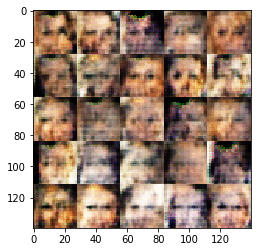

Epoch 1/1... Discriminator Loss:1.3540... Generator Loss:0.7712
Epoch 1/1... Discriminator Loss:1.3912... Generator Loss:0.7765
Epoch 1/1... Discriminator Loss:1.3735... Generator Loss:0.7718
Epoch 1/1... Discriminator Loss:1.3830... Generator Loss:0.7845
Epoch 1/1... Discriminator Loss:1.3888... Generator Loss:0.8322
Epoch 1/1... Discriminator Loss:1.3710... Generator Loss:0.8730
Epoch 1/1... Discriminator Loss:1.3847... Generator Loss:0.7756
Epoch 1/1... Discriminator Loss:1.3871... Generator Loss:0.8258
Epoch 1/1... Discriminator Loss:1.4589... Generator Loss:0.7583
Epoch 1/1... Discriminator Loss:1.3586... Generator Loss:0.7577


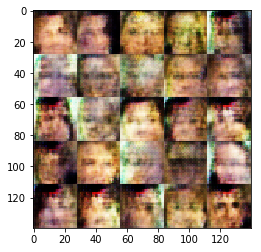

Epoch 1/1... Discriminator Loss:1.4159... Generator Loss:0.8075
Epoch 1/1... Discriminator Loss:1.3609... Generator Loss:0.8185
Epoch 1/1... Discriminator Loss:1.4106... Generator Loss:0.7717
Epoch 1/1... Discriminator Loss:1.3883... Generator Loss:0.8075
Epoch 1/1... Discriminator Loss:1.3944... Generator Loss:0.7779
Epoch 1/1... Discriminator Loss:1.3980... Generator Loss:0.7315
Epoch 1/1... Discriminator Loss:1.4314... Generator Loss:0.7271
Epoch 1/1... Discriminator Loss:1.4070... Generator Loss:0.7770
Epoch 1/1... Discriminator Loss:1.3553... Generator Loss:0.8425
Epoch 1/1... Discriminator Loss:1.3752... Generator Loss:0.7676


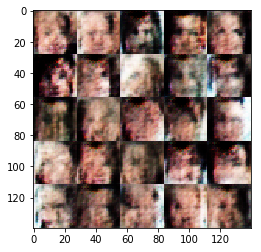

Epoch 1/1... Discriminator Loss:1.3525... Generator Loss:0.8091
Epoch 1/1... Discriminator Loss:1.4077... Generator Loss:0.7771
Epoch 1/1... Discriminator Loss:1.4442... Generator Loss:0.7010
Epoch 1/1... Discriminator Loss:1.4018... Generator Loss:0.7970
Epoch 1/1... Discriminator Loss:1.3858... Generator Loss:0.7967
Epoch 1/1... Discriminator Loss:1.3458... Generator Loss:0.8230
Epoch 1/1... Discriminator Loss:1.4036... Generator Loss:0.8438
Epoch 1/1... Discriminator Loss:1.3820... Generator Loss:0.7713
Epoch 1/1... Discriminator Loss:1.3965... Generator Loss:0.7597
Epoch 1/1... Discriminator Loss:1.3893... Generator Loss:0.8334


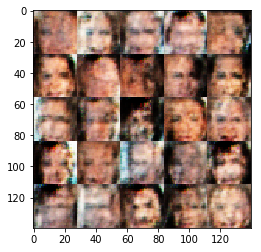

Epoch 1/1... Discriminator Loss:1.3658... Generator Loss:0.7870
Epoch 1/1... Discriminator Loss:1.3988... Generator Loss:0.7609
Epoch 1/1... Discriminator Loss:1.3712... Generator Loss:0.7778
Epoch 1/1... Discriminator Loss:1.3818... Generator Loss:0.7809
Epoch 1/1... Discriminator Loss:1.4167... Generator Loss:0.7653
Epoch 1/1... Discriminator Loss:1.3590... Generator Loss:0.8336
Epoch 1/1... Discriminator Loss:1.4291... Generator Loss:0.8351
Epoch 1/1... Discriminator Loss:1.3978... Generator Loss:0.7734
Epoch 1/1... Discriminator Loss:1.3802... Generator Loss:0.7924
Epoch 1/1... Discriminator Loss:1.3873... Generator Loss:0.7790


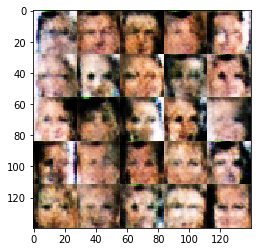

Epoch 1/1... Discriminator Loss:1.3830... Generator Loss:0.7511
Epoch 1/1... Discriminator Loss:1.3819... Generator Loss:0.7648
Epoch 1/1... Discriminator Loss:1.3920... Generator Loss:0.6943
Epoch 1/1... Discriminator Loss:1.3712... Generator Loss:0.8329
Epoch 1/1... Discriminator Loss:1.3679... Generator Loss:0.8018
Epoch 1/1... Discriminator Loss:1.3744... Generator Loss:0.7595
Epoch 1/1... Discriminator Loss:1.3900... Generator Loss:0.7503
Epoch 1/1... Discriminator Loss:1.3882... Generator Loss:0.7950
Epoch 1/1... Discriminator Loss:1.4136... Generator Loss:0.7799
Epoch 1/1... Discriminator Loss:1.3607... Generator Loss:0.8072


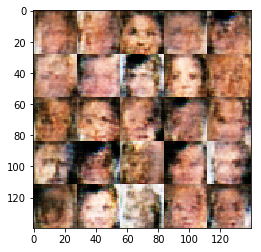

Epoch 1/1... Discriminator Loss:1.3784... Generator Loss:0.7666
Epoch 1/1... Discriminator Loss:1.3813... Generator Loss:0.8054
Epoch 1/1... Discriminator Loss:1.3700... Generator Loss:0.8025
Epoch 1/1... Discriminator Loss:1.4226... Generator Loss:0.8354
Epoch 1/1... Discriminator Loss:1.4062... Generator Loss:0.7611
Epoch 1/1... Discriminator Loss:1.4571... Generator Loss:0.8203
Epoch 1/1... Discriminator Loss:1.4238... Generator Loss:0.7319
Epoch 1/1... Discriminator Loss:1.4087... Generator Loss:0.7337
Epoch 1/1... Discriminator Loss:1.3960... Generator Loss:0.8636
Epoch 1/1... Discriminator Loss:1.3502... Generator Loss:0.7911


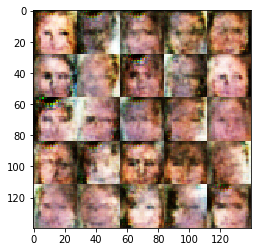

Epoch 1/1... Discriminator Loss:1.3981... Generator Loss:0.8123
Epoch 1/1... Discriminator Loss:1.3604... Generator Loss:0.8182
Epoch 1/1... Discriminator Loss:1.4007... Generator Loss:0.8034
Epoch 1/1... Discriminator Loss:1.3815... Generator Loss:0.7729
Epoch 1/1... Discriminator Loss:1.4128... Generator Loss:0.8046
Epoch 1/1... Discriminator Loss:1.3813... Generator Loss:0.7219
Epoch 1/1... Discriminator Loss:1.3763... Generator Loss:0.8080
Epoch 1/1... Discriminator Loss:1.4162... Generator Loss:0.7436
Epoch 1/1... Discriminator Loss:1.3413... Generator Loss:0.7986
Epoch 1/1... Discriminator Loss:1.3897... Generator Loss:0.7978


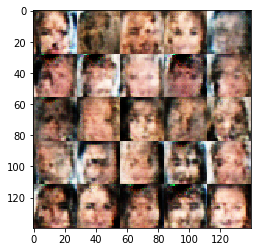

Epoch 1/1... Discriminator Loss:1.3977... Generator Loss:0.7262
Epoch 1/1... Discriminator Loss:1.3763... Generator Loss:0.8322
Epoch 1/1... Discriminator Loss:1.3977... Generator Loss:0.7429
Epoch 1/1... Discriminator Loss:1.3896... Generator Loss:0.7630
Epoch 1/1... Discriminator Loss:1.3931... Generator Loss:0.7860
Epoch 1/1... Discriminator Loss:1.4012... Generator Loss:0.7485
Epoch 1/1... Discriminator Loss:1.4093... Generator Loss:0.7860
Epoch 1/1... Discriminator Loss:1.3496... Generator Loss:0.7913
Epoch 1/1... Discriminator Loss:1.4025... Generator Loss:0.8067
Epoch 1/1... Discriminator Loss:1.3726... Generator Loss:0.7762


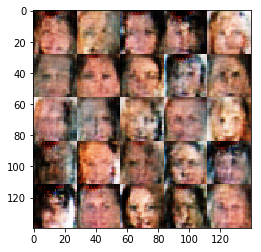

Epoch 1/1... Discriminator Loss:1.3667... Generator Loss:0.8196
Epoch 1/1... Discriminator Loss:1.3554... Generator Loss:0.8369
Epoch 1/1... Discriminator Loss:1.3849... Generator Loss:0.7166
Epoch 1/1... Discriminator Loss:1.3930... Generator Loss:0.8115
Epoch 1/1... Discriminator Loss:1.3912... Generator Loss:0.7352
Epoch 1/1... Discriminator Loss:1.3836... Generator Loss:0.7428
Epoch 1/1... Discriminator Loss:1.3906... Generator Loss:0.7577
Epoch 1/1... Discriminator Loss:1.4164... Generator Loss:0.7138
Epoch 1/1... Discriminator Loss:1.4127... Generator Loss:0.7603
Epoch 1/1... Discriminator Loss:1.3693... Generator Loss:0.7997


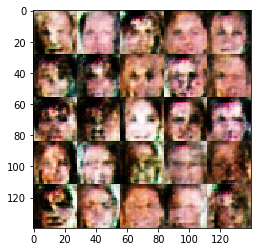

Epoch 1/1... Discriminator Loss:1.3869... Generator Loss:0.7969
Epoch 1/1... Discriminator Loss:1.3918... Generator Loss:0.7779
Epoch 1/1... Discriminator Loss:1.3985... Generator Loss:0.7705
Epoch 1/1... Discriminator Loss:1.4067... Generator Loss:0.7755
Epoch 1/1... Discriminator Loss:1.3635... Generator Loss:0.7982
Epoch 1/1... Discriminator Loss:1.3972... Generator Loss:0.7751
Epoch 1/1... Discriminator Loss:1.3774... Generator Loss:0.7742
Epoch 1/1... Discriminator Loss:1.3520... Generator Loss:0.8174
Epoch 1/1... Discriminator Loss:1.4002... Generator Loss:0.7147
Epoch 1/1... Discriminator Loss:1.3873... Generator Loss:0.8283


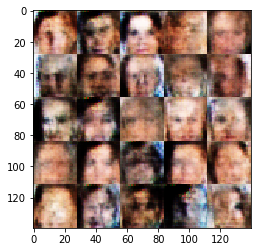

Epoch 1/1... Discriminator Loss:1.3767... Generator Loss:0.7607
Epoch 1/1... Discriminator Loss:1.3847... Generator Loss:0.7450
Epoch 1/1... Discriminator Loss:1.3868... Generator Loss:0.8110
Epoch 1/1... Discriminator Loss:1.3859... Generator Loss:0.7882
Epoch 1/1... Discriminator Loss:1.3863... Generator Loss:0.7739
Epoch 1/1... Discriminator Loss:1.4016... Generator Loss:0.7413
Epoch 1/1... Discriminator Loss:1.3888... Generator Loss:0.7762
Epoch 1/1... Discriminator Loss:1.3845... Generator Loss:0.7949
Epoch 1/1... Discriminator Loss:1.3723... Generator Loss:0.7791
Epoch 1/1... Discriminator Loss:1.3809... Generator Loss:0.8092


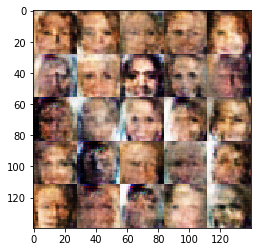

Epoch 1/1... Discriminator Loss:1.3999... Generator Loss:0.7898
Epoch 1/1... Discriminator Loss:1.3919... Generator Loss:0.7887
Epoch 1/1... Discriminator Loss:1.3773... Generator Loss:0.7933
Epoch 1/1... Discriminator Loss:1.3739... Generator Loss:0.7618
Epoch 1/1... Discriminator Loss:1.3647... Generator Loss:0.8216
Epoch 1/1... Discriminator Loss:1.4034... Generator Loss:0.7797
Epoch 1/1... Discriminator Loss:1.4003... Generator Loss:0.7576
Epoch 1/1... Discriminator Loss:1.3762... Generator Loss:0.7888
Epoch 1/1... Discriminator Loss:1.3956... Generator Loss:0.7720
Epoch 1/1... Discriminator Loss:1.3956... Generator Loss:0.7840


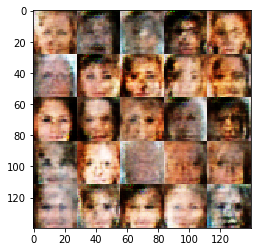

Epoch 1/1... Discriminator Loss:1.3829... Generator Loss:0.8062
Epoch 1/1... Discriminator Loss:1.3701... Generator Loss:0.7823
Epoch 1/1... Discriminator Loss:1.3778... Generator Loss:0.7633
Epoch 1/1... Discriminator Loss:1.3958... Generator Loss:0.7956
Epoch 1/1... Discriminator Loss:1.3920... Generator Loss:0.7884
Epoch 1/1... Discriminator Loss:1.3669... Generator Loss:0.7716
Epoch 1/1... Discriminator Loss:1.3977... Generator Loss:0.8049
Epoch 1/1... Discriminator Loss:1.3916... Generator Loss:0.7639
Epoch 1/1... Discriminator Loss:1.3721... Generator Loss:0.7748
Epoch 1/1... Discriminator Loss:1.3849... Generator Loss:0.7566


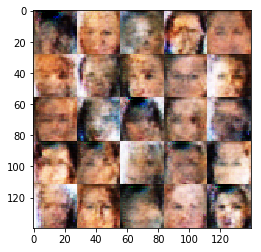

Epoch 1/1... Discriminator Loss:1.4005... Generator Loss:0.7797
Epoch 1/1... Discriminator Loss:1.3889... Generator Loss:0.7511
Epoch 1/1... Discriminator Loss:1.3870... Generator Loss:0.7838
Epoch 1/1... Discriminator Loss:1.3826... Generator Loss:0.8053
Epoch 1/1... Discriminator Loss:1.3943... Generator Loss:0.7794
Epoch 1/1... Discriminator Loss:1.3764... Generator Loss:0.8174
Epoch 1/1... Discriminator Loss:1.3869... Generator Loss:0.7665
Epoch 1/1... Discriminator Loss:1.3862... Generator Loss:0.8254
Epoch 1/1... Discriminator Loss:1.3836... Generator Loss:0.7984
Epoch 1/1... Discriminator Loss:1.3831... Generator Loss:0.7924


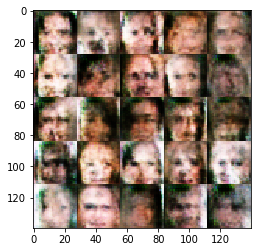

Epoch 1/1... Discriminator Loss:1.3914... Generator Loss:0.7445
Epoch 1/1... Discriminator Loss:1.3794... Generator Loss:0.7674
Epoch 1/1... Discriminator Loss:1.3757... Generator Loss:0.8010
Epoch 1/1... Discriminator Loss:1.3876... Generator Loss:0.7899
Epoch 1/1... Discriminator Loss:1.3671... Generator Loss:0.7960
Epoch 1/1... Discriminator Loss:1.3836... Generator Loss:0.7924
Epoch 1/1... Discriminator Loss:1.3814... Generator Loss:0.7693
Epoch 1/1... Discriminator Loss:1.3756... Generator Loss:0.8036
Epoch 1/1... Discriminator Loss:1.3678... Generator Loss:0.8357
Epoch 1/1... Discriminator Loss:1.3969... Generator Loss:0.7999


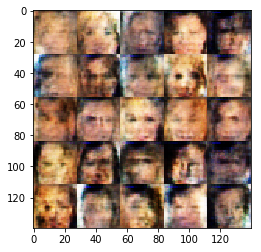

Epoch 1/1... Discriminator Loss:1.3762... Generator Loss:0.7952
Epoch 1/1... Discriminator Loss:1.3864... Generator Loss:0.7854
Epoch 1/1... Discriminator Loss:1.3788... Generator Loss:0.7680
Epoch 1/1... Discriminator Loss:1.3679... Generator Loss:0.8012
Epoch 1/1... Discriminator Loss:1.3850... Generator Loss:0.7660
Epoch 1/1... Discriminator Loss:1.3625... Generator Loss:0.7982
Epoch 1/1... Discriminator Loss:1.3903... Generator Loss:0.8216
Epoch 1/1... Discriminator Loss:1.3896... Generator Loss:0.7541
Epoch 1/1... Discriminator Loss:1.4018... Generator Loss:0.7935
Epoch 1/1... Discriminator Loss:1.3851... Generator Loss:0.7736


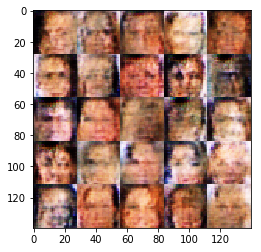

Epoch 1/1... Discriminator Loss:1.3833... Generator Loss:0.7915
Epoch 1/1... Discriminator Loss:1.3565... Generator Loss:0.8151
Epoch 1/1... Discriminator Loss:1.3696... Generator Loss:0.7860
Epoch 1/1... Discriminator Loss:1.3918... Generator Loss:0.7812
Epoch 1/1... Discriminator Loss:1.3914... Generator Loss:0.8050
Epoch 1/1... Discriminator Loss:1.3701... Generator Loss:0.7954
Epoch 1/1... Discriminator Loss:1.3750... Generator Loss:0.7824
Epoch 1/1... Discriminator Loss:1.3696... Generator Loss:0.7966
Epoch 1/1... Discriminator Loss:1.3808... Generator Loss:0.8103
Epoch 1/1... Discriminator Loss:1.3790... Generator Loss:0.7870


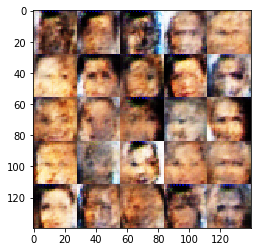

Epoch 1/1... Discriminator Loss:1.3743... Generator Loss:0.7960
Epoch 1/1... Discriminator Loss:1.3821... Generator Loss:0.8077
Epoch 1/1... Discriminator Loss:1.3795... Generator Loss:0.8219
Epoch 1/1... Discriminator Loss:1.3664... Generator Loss:0.7743
Epoch 1/1... Discriminator Loss:1.3945... Generator Loss:0.7826
Epoch 1/1... Discriminator Loss:1.3645... Generator Loss:0.7740
Epoch 1/1... Discriminator Loss:1.3711... Generator Loss:0.7750
Epoch 1/1... Discriminator Loss:1.3991... Generator Loss:0.7807
Epoch 1/1... Discriminator Loss:1.3619... Generator Loss:0.8006
Epoch 1/1... Discriminator Loss:1.3646... Generator Loss:0.7939


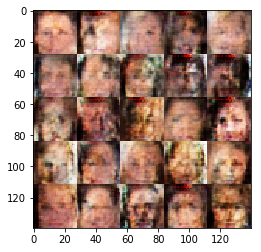

Epoch 1/1... Discriminator Loss:1.3870... Generator Loss:0.7898
Epoch 1/1... Discriminator Loss:1.3709... Generator Loss:0.7726
Epoch 1/1... Discriminator Loss:1.3954... Generator Loss:0.7860
Epoch 1/1... Discriminator Loss:1.3772... Generator Loss:0.7894
Epoch 1/1... Discriminator Loss:1.3660... Generator Loss:0.8378
Epoch 1/1... Discriminator Loss:1.3710... Generator Loss:0.7751
Epoch 1/1... Discriminator Loss:1.3797... Generator Loss:0.7876
Epoch 1/1... Discriminator Loss:1.3772... Generator Loss:0.7453
Epoch 1/1... Discriminator Loss:1.3887... Generator Loss:0.7948
Epoch 1/1... Discriminator Loss:1.3652... Generator Loss:0.8088


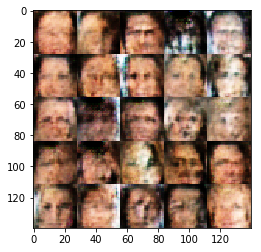

Epoch 1/1... Discriminator Loss:1.3856... Generator Loss:0.7464
Epoch 1/1... Discriminator Loss:1.3938... Generator Loss:0.7721
Epoch 1/1... Discriminator Loss:1.3962... Generator Loss:0.7862
Epoch 1/1... Discriminator Loss:1.3721... Generator Loss:0.7736
Epoch 1/1... Discriminator Loss:1.3884... Generator Loss:0.7735
Epoch 1/1... Discriminator Loss:1.3785... Generator Loss:0.8301
Epoch 1/1... Discriminator Loss:1.3661... Generator Loss:0.7163
Epoch 1/1... Discriminator Loss:1.3885... Generator Loss:0.8105
Epoch 1/1... Discriminator Loss:1.3828... Generator Loss:0.7815
Epoch 1/1... Discriminator Loss:1.3537... Generator Loss:0.8097


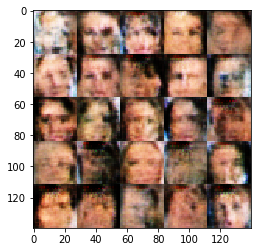

Epoch 1/1... Discriminator Loss:1.3856... Generator Loss:0.8113
Epoch 1/1... Discriminator Loss:1.3650... Generator Loss:0.8146
Epoch 1/1... Discriminator Loss:1.3467... Generator Loss:0.7976
Epoch 1/1... Discriminator Loss:1.3646... Generator Loss:0.8385
Epoch 1/1... Discriminator Loss:1.3755... Generator Loss:0.7711
Epoch 1/1... Discriminator Loss:1.3723... Generator Loss:0.8083
Epoch 1/1... Discriminator Loss:1.3818... Generator Loss:0.7834
Epoch 1/1... Discriminator Loss:1.3826... Generator Loss:0.7632
Epoch 1/1... Discriminator Loss:1.3807... Generator Loss:0.7905
Epoch 1/1... Discriminator Loss:1.3865... Generator Loss:0.7657


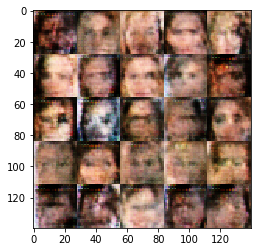

Epoch 1/1... Discriminator Loss:1.3926... Generator Loss:0.7727
Epoch 1/1... Discriminator Loss:1.4082... Generator Loss:0.7491
Epoch 1/1... Discriminator Loss:1.3639... Generator Loss:0.8159
Epoch 1/1... Discriminator Loss:1.3754... Generator Loss:0.8290
Epoch 1/1... Discriminator Loss:1.3644... Generator Loss:0.7721
Epoch 1/1... Discriminator Loss:1.3944... Generator Loss:0.8094
Epoch 1/1... Discriminator Loss:1.3812... Generator Loss:0.7735
Epoch 1/1... Discriminator Loss:1.3829... Generator Loss:0.7861
Epoch 1/1... Discriminator Loss:1.3852... Generator Loss:0.7847
Epoch 1/1... Discriminator Loss:1.3586... Generator Loss:0.8167


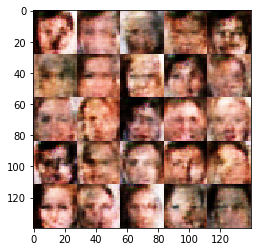

Epoch 1/1... Discriminator Loss:1.3897... Generator Loss:0.7801
Epoch 1/1... Discriminator Loss:1.3773... Generator Loss:0.7851
Epoch 1/1... Discriminator Loss:1.3655... Generator Loss:0.8120
Epoch 1/1... Discriminator Loss:1.3671... Generator Loss:0.7780
Epoch 1/1... Discriminator Loss:1.3830... Generator Loss:0.8079
Epoch 1/1... Discriminator Loss:1.3667... Generator Loss:0.8169


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.